![Titlepic](Images/xyzab_machine_alpha.png)

# Introduction


This paper describes how to derive the kinematic model for a 5-axis machine tool in an XYZAB configuration with dual table rotation. In this example the B axis is the primary and the A axis is the secondary rotary axis. The primary being independent of the secondary axis. The model presented here will be named 'XYZAB-TDR'.

The method used here will be a step by step approach. Starting with a working kinematic model for a single rotary axis all the required elements will be added to build a complete kinematic model for the machine.

The final model includes tool-length compensation, compensation for mechanical offsets between the two rotational axis A and B and compensation for setups where the machine reference point is not located in the rotation-point of the rotary assembly.  

In this document only basic mathematical functions are used so the kinematic models derived can be used directly in the 'userkins.comp' template file provided with the LinuxCNC installation. All calculations can be done without the use of any computer algebra systems, however the use of computer assistance like 'sage' will make the process of matrix multiplication much less error prone.

Note that there are other and potentially more computationally efficient ways to build custom kinematics using built in libraries like 'posemath'. Posemath provides many functions for efficient matrix manipulation and also offers functions for the use of quaternions. However the use of such a library would require a more indepth understanding of the mathematical theory that is beyond the scope of this presentation. Furthermore importing a library like 'posemath' into the 'userkins.comp' template would require substantially more programming skills than using the method applied in this paper. 

In [1]:
from IPython.display import display, Image

# only used to display equations out of code blocks
from IPython.display import Math, display

# joint position vector P 
var('Px','Py','Pz')
P_=matrix([[Px],
           [Py],
           [Pz],
           [1]])

# cartesian position vector Q
var('Qx','Qy','Qz')
Q_=matrix([[Qx],
           [Qy],
           [Qz],
           [1]])

A custom kinematic model in LinuxCNC is used to calculate cartesian coordinates from given machine joint positions (forward kinematics) and also to calculate the required machine joint positions to reach a given coordinate position (inverse kinematics). In the following description we will use vectors as mathematical representations of the two positions: 


\begin{equation}
Q ~=~
\left(\begin{array}{rrrr}
  Qx \\
  Qy \\
  Qz \\
  1
\end{array}\right)
~
Cartesian~position
~~~~~~~~~~~~
P ~=~
\left(\begin{array}{rrrr}
  Px \\
  Py \\
  Pz \\
  1
\end{array}\right)
~
Joint~position
\end{equation}

Note that the fourth row is added to be able to multiply the vectors with a 4x4 transformation matrix. 

# Kinematic transformation 

The kinematic model consists of a 'Forward' transformation and an 'Inverse' transformation. <br>
The forward transformation uses known machine joint locations and calculates the corresponding axis locations (ie any XYZABCUVW) usually tool position and orientation in the work space. In Linuxcnc the forward kinematic is used to calculate the initial axis positions after homing the machine.<br>
The inverse transformation calculates the required machine joint positions to move the control point (usually the tool tip) to the given coordinates (ie XYZABCUVW). 

# TCP Kinematic model
For the tool to follow a point on the work piece we need a model that calculates where a given position on the work piece moves to when the rotary joints are rotated. In our example configuration the work piece will be mounted on the A rotary table.<br>

For the forward kinematic model we start at the tool side and work along the kinematic chain towards the work piece so we will start with the primary rotary.<br>


Note that in matrix multiplication the order is important that is $A\cdot B$ is generally not equal to $B \cdot A$. 

## Table Primary Rotation
### Forward transformation

In this case the forward transformation matrix for the secondary rotation is equal to a rotation around the y-axis:

\begin{equation}
 ^QA_P=~ R_p 
\label{eq:trns_fwd}
\end{equation}



In [2]:
var('Cp','Sp')
Rp=matrix([[Cp,  0,  Sp,  0],
           [ 0,  1,   0,  0],
           [-Sp,  0,  Cp, 0],
           [ 0,  0,   0, 1]])
display(Math(rf'R_p =~'+latex(Rp)))

<IPython.core.display.Math object>

with $~~Sp = sin(\theta_p),~~~ Cp = cos(\theta_p)$
and $\theta_p$ being the angle of rotation around the primary rotary joint

In [3]:
# calculate the forward transformation matrix
qAp=Rp
display(Math(rf'^QA_P =~~'+latex(Rp)))

<IPython.core.display.Math object>

In [4]:
# calculate the forward kinematic
Q_out=qAp*P_
display(Math(rf'Q =~'+latex(Q_)+rf'=~^QA_P \cdot P=~~'+latex(qAp)+rf'\cdot'+latex(P_)+rf'=~~~'+latex(Q_out)))

<IPython.core.display.Math object>

In [5]:
# Extract the tool-position vector Q (FORWARD KINEMATICS) from
# the fourth column of the forward transformation matrix
display(Math(latex(Q_[0][0]) + rf'~=~'  + latex(Q_out[0])))
display(Math(latex(Q_[1][0]) + rf'~=~'  + latex(Q_out[1])))
display(Math(latex(Q_[2][0]) + rf'~=~'  + latex(Q_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:
# expressions as used in kinematics component
print('//TCP kinematics FORWARD')
print('pos->tran.x = ', Q_out[0], ';')
print('pos->tran.y = ', Q_out[1], ';')
print('pos->tran.z = ', Q_out[2], ';')

//TCP kinematics FORWARD
pos->tran.x =  (Cp*Px + Pz*Sp) ;
pos->tran.y =  (Py) ;
pos->tran.z =  (Cp*Pz - Px*Sp) ;


### Inverse transformation

To calculate the joint position $P$ from given coordinate positions $Q$ we need to 'unrotate' the primary rotary joint. Mathematically this means we need to transpose the rotation part in our transformation matrix.

\begin{equation}
 ^PA_Q=~ R_p^T 
\end{equation}

In [7]:
# calculate the inverse transformation matrix
pAq=Rp.transpose()
display(Math(rf'^PA_Q =~~'+latex(Rp.transpose())))

<IPython.core.display.Math object>

To derive the joint position $P$ we then multiply the coordinate position vector $Q$ from the right:

\begin{equation}
 P=~^PA_Q \cdot Q
\end{equation}

In [8]:
# calculate the inverse kinematic
P_out=pAq*Q_
display(Math(rf'P =~'+latex(P_)+rf'=~^PA_Q \cdot Q=~~'+rf'=~'+latex(pAq)+rf'\cdot'+latex(Q_)+rf'=~'+latex(P_out)))

<IPython.core.display.Math object>

In [9]:
# Extract the joint-position vector P (INVERSE KINEMATICS) from
# the fourth column of the inverse transformation matrix
display(Math(latex(P_[0][0]) + rf'~=~'  + latex(P_out[0])))
display(Math(latex(P_[1][0]) + rf'~=~'  + latex(P_out[1])))
display(Math(latex(P_[2][0]) + rf'~=~'  + latex(P_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [10]:
# expressions as used in kinematics component
print('//TCP kinematics INVERSE')
print('j[0] = ', P_out[0], ';')
print('j[1] = ', P_out[1], ';')
print('j[2] = ', P_out[2], ';')

//TCP kinematics INVERSE
j[0] =  (Cp*Qx - Qz*Sp) ;
j[1] =  (Qy) ;
j[2] =  (Cp*Qz + Qx*Sp) ;


## Table Secondary Rotation
### Forward transformation

In this case the forward transformation matrix for the secondary rotation is equal to a rotation around the x-axis:

In [11]:
# define transformation matrix for the secondary rotary (ie rotation around z-axis)
var('Cs','Ss')
Rs=matrix([[ 1,  0,   0, 0],
           [ 0, Cs, -Ss, 0],
           [ 0, Ss,  Cs, 0],
           [ 0,  0,   0, 1]])
display(Math(rf'R_s =~'+latex(Rs)))

<IPython.core.display.Math object>

with $~~Ss = sin(\theta_s),~~~ Cs = cos(\theta_s)$
and $\theta_s$ being the angle of rotation around the secondary rotary joint

To build the forward transformation matrix $^QA_P$ for the primary and the secondary rotation we need to multipy $R_s$  with $R_p$ from the left:

\begin{equation}
 ^QA_P=~ R_s \cdot R_p 
\label{eq:trns_fwd}
\end{equation}

In [12]:
# calculate the forward transformation matrix
qAp=Rs*Rp
display(Math(rf'^QA_P =~~'+latex(Rs)+rf'\cdot'+latex(Rp)+rf'=~~'+latex(qAp)))

<IPython.core.display.Math object>

In [13]:
# calculate the forward kinematic
Q_out=qAp*P_
display(Math(rf'Q =~'+latex(Q_)+rf'=~^QA_P \cdot P'+rf'=~'+latex(qAp)+rf'\cdot'+latex(P_)+rf'=~'+latex(Q_out)))

<IPython.core.display.Math object>

In [14]:
# Extract the tool-position vector Q (FORWARD KINEMATICS) from
# the fourth column of the forward transformation matrix
display(Math(latex(Q_[0][0]) + rf'~=~'  + latex(Q_out[0])))
display(Math(latex(Q_[1][0]) + rf'~=~'  + latex(Q_out[1])))
display(Math(latex(Q_[2][0]) + rf'~=~'  + latex(Q_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [15]:
# expressions as used in kinematics component
print('//TCP kinematics FORWARD')
print('pos->tran.x = ', Q_out[0], ';')
print('pos->tran.y = ', Q_out[1], ';')
print('pos->tran.z = ', Q_out[2], ';')

//TCP kinematics FORWARD
pos->tran.x =  (Cp*Px + Pz*Sp) ;
pos->tran.y =  (-Cp*Pz*Ss + Px*Sp*Ss + Cs*Py) ;
pos->tran.z =  (Cp*Cs*Pz - Cs*Px*Sp + Py*Ss) ;


### Inverse transformation

To calculate the joint position $P$ from given coordinate positions $Q$ we now need to first 'unrotate' the secondary rotary joint and then the primary joint. Mathematically this means we need to multiply $R_p^T$ with $R_s^T$ from the left .

\begin{equation}
 ^PA_Q=~ R_p^T \cdot  R_s^T
\end{equation}


In [16]:
# calculate the inverse transformation matrix
pAq=Rp.transpose()*Rs.transpose()
display(Math(rf'^PA_Q =~~'+latex(Rp.transpose())+rf'\cdot'+latex(Rs.transpose())))

<IPython.core.display.Math object>

To derive the joint position $P$ we then multiply the coordinate position vector $Q$ from the right:

\begin{equation}
 P=~^PA_Q \cdot Q
\end{equation}

In [17]:
# calculate the inverse kinematic
P_out=pAq*Q_
display(Math(rf'P =~'+latex(P_)+rf'=~'+latex(pAq)+rf'\cdot'+latex(Q_)+rf'=~'+latex(P_out)))

<IPython.core.display.Math object>

In [18]:
# Extract the joint-position vector P (INVERSE KINEMATICS) from
# the fourth column of the inverse transformation matrix
display(Math(latex(P_[0][0]) + rf'~=~'  + latex(P_out[0])))
display(Math(latex(P_[1][0]) + rf'~=~'  + latex(P_out[1])))
display(Math(latex(P_[2][0]) + rf'~=~'  + latex(P_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [19]:
# expressions as used in kinematics component
print('//TCP kinematics INVERSE')
print('j[0] = ', P_out[0], ';')
print('j[1] = ', P_out[1], ';')
print('j[2] = ', P_out[2], ';')

//TCP kinematics INVERSE
j[0] =  (-Cs*Qz*Sp + Qy*Sp*Ss + Cp*Qx) ;
j[1] =  (Cs*Qy + Qz*Ss) ;
j[2] =  (Cp*Cs*Qz - Cp*Qy*Ss + Qx*Sp) ;


Testing in LinuxCNC now shows a working TCP kinematic for rotations of both joints A and B

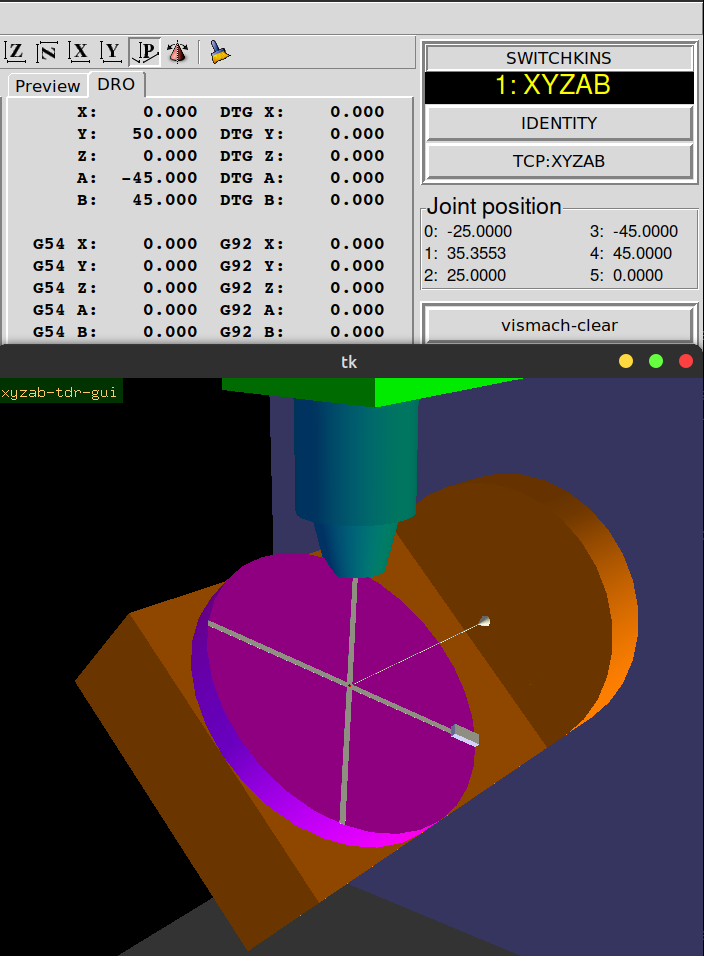

In [20]:
display(Image(filename="Images/ab_gui.png",
              height=300, width=300))

## Offsets in the rotary assembly
The rotational axes of a rotary assembly like the A/B type discussed here will always have an intended or unintented offset from one rotational axis to the other. In our case this is an offset in the x direction (red indicator) and in the z direction (blue indicator). In the image the yellow rod indicates the rotational axis of B and the yellow cross at it's end indicates where the axis A and axis B intersect when both x- and z-offset are zero this is also called the 'rotation point' of the rotary assembly.
We define the values for the offsets in the example image as *x-offset = -20* and *z-offset = -10*. In our kinematic model this represents the situation where, starting from the rotation point of the rotary assembly, we need to travel 10 in the negative z-direction and 20 in the negative x-direction to reach the center of the face of the rotary A.

Note that the direction of travel when defining these offsets is arbitrary so in our case the offset situation in the image could also be defined as +20 in x and +10 in z. However once the definition is made we must keep it through the entire process of building the kinematic model.

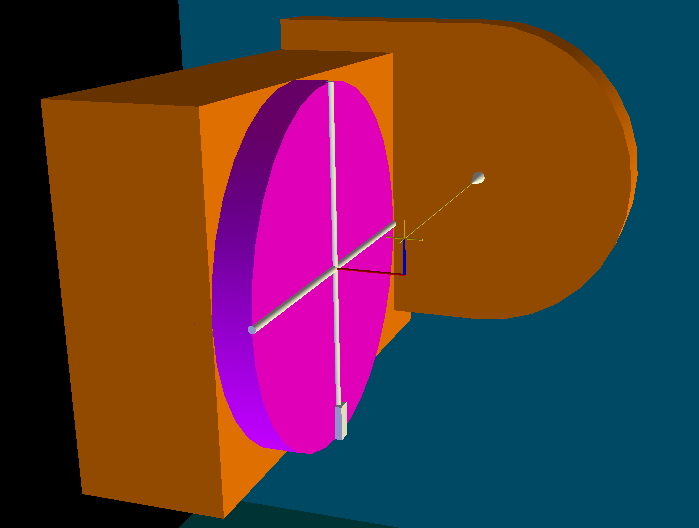

In [21]:

display(Image(filename="Images/offsets_xz_1.png", 
              height=300, width=300))

### Forward transformation

Because these offsets are located in between the two rotations they also need to be built in between the rotations in our transformation matrix. It may be helpful to view the offsets as the components of a vector. In our case the vector components would be (-20,0,-10) so the vector would point from the rotation point to the face of the rotary table A. 
To build the transformation matrix that describes these offsets we need to keep in mind if we are moving with or against the offset vector as we travel from the work to the spindle. In our case we defined the offset vector to point towards the rotary A so we are travelling in the opposite direction and thus the vector components need to be entered in the negative.

\begin{equation}
 ^QA_P=~ R_s \cdot T_o \cdot R_p
\end{equation}

In [22]:
# define the forward transformation for the geometric offsets
var('Dx','Dz')
To=matrix([[ 1, 0, 0, -Dx],
           [ 0, 1, 0,  0 ],
           [ 0, 0, 1, -Dz],
           [ 0, 0, 0,  1 ]])
display(Math(rf'T_o =~'+latex(To)))

<IPython.core.display.Math object>

In [23]:
# calculate the forward transformation matrix
qAp=Rs*To*Rp
display(Math(rf'^QA_P =~~'+latex(Rs)+rf'\cdot'+latex(To)+rf'\cdot'+latex(Rp)+latex(qAp)))

<IPython.core.display.Math object>

In [24]:
# calculate the forward kinematic
Q_out=qAp*P_
display(Math(rf'Q =~'+latex(Q_)+rf'=~^QA_P \cdot P'+rf'=~'+latex(qAp)+rf'\cdot'+latex(P_)+rf'=~'+latex(Q_out)))

<IPython.core.display.Math object>

In [25]:
# Extract the tool-position vector Q (FORWARD KINEMATICS) from
# the fourth column of the forward transformation matrix
display(Math(latex(Q_[0][0]) + rf'~=~'  + latex(Q_out[0])))
display(Math(latex(Q_[1][0]) + rf'~=~'  + latex(Q_out[1])))
display(Math(latex(Q_[2][0]) + rf'~=~'  + latex(Q_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [26]:
# expressions as used in kinematics component
print('//TCP kinematics FORWARD')
print('pos->tran.x = ', Q_out[0], ';')
print('pos->tran.y = ', Q_out[1], ';')
print('pos->tran.z = ', Q_out[2], ';')

//TCP kinematics FORWARD
pos->tran.x =  (Cp*Px + Pz*Sp - Dx) ;
pos->tran.y =  (-Cp*Pz*Ss + Px*Sp*Ss + Cs*Py + Dz*Ss) ;
pos->tran.z =  (Cp*Cs*Pz - Cs*Px*Sp - Cs*Dz + Py*Ss) ;


### Inverse transformation

In the inverse transformation

\begin{equation}
 ^PA_Q=~ R_p^T \cdot  T_{io} \cdot  R_s^T
\end{equation}

Where $T_{io}$ is the inverted offset vector translation:

In [27]:
# define the inverse transformation for the geometric offsets
Tio=matrix([[ 1, 0, 0, Dx],
            [ 0, 1, 0, 0 ],
            [ 0, 0, 1, Dz],
            [ 0, 0, 0, 1 ]])
display(Math(rf'T_io =~'+latex(Tio)))

<IPython.core.display.Math object>

In [28]:
# calculate inverse transformation matrix
pAq=Rp.transpose()*Tio*Rs.transpose()
display(Math(rf'^PA_Q=~'+latex(Rp.transpose())+rf'\cdot'+latex(Tio)+rf'\cdot'+latex(Rs.transpose())))
display(Math(rf'^PA_Q =~~'+latex(pAq)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [29]:
# calculate the inverse kinematic
P_out=pAq*Q_
display(Math(rf'P =~'+latex(P_)+rf'=~'+latex(pAq)+rf'\cdot'+latex(Q_)+rf'=~'+latex(P_out)))

<IPython.core.display.Math object>

In [30]:
# Extract the tool-position vector Q (FORWARD KINEMATICS) from
# the fourth column of the forward transformation matrix
display(Math(latex(Q_[0][0]) + rf'~=~'  + latex(Q_out[0])))
display(Math(latex(Q_[1][0]) + rf'~=~'  + latex(Q_out[1])))
display(Math(latex(Q_[2][0]) + rf'~=~'  + latex(Q_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [31]:
# expressions as used in kinematics component
print('//TCP kinematics INVERSE')
print('j[0] = ', P_out[0], ';')
print('j[1] = ', P_out[1], ';')
print('j[2] = ', P_out[2], ';')

//TCP kinematics INVERSE
j[0] =  (-Cs*Qz*Sp + Qy*Sp*Ss + Cp*Dx + Cp*Qx - Dz*Sp) ;
j[1] =  (Cs*Qy + Qz*Ss) ;
j[2] =  (Cp*Cs*Qz - Cp*Qy*Ss + Cp*Dz + Dx*Sp + Qx*Sp) ;


Testing in LinuxCNC shows a working TCP kinematic for rotations of joints A and B and the machine reference point has now shifted from the rotation point of the rotary assembly to the face center of the rotary A.

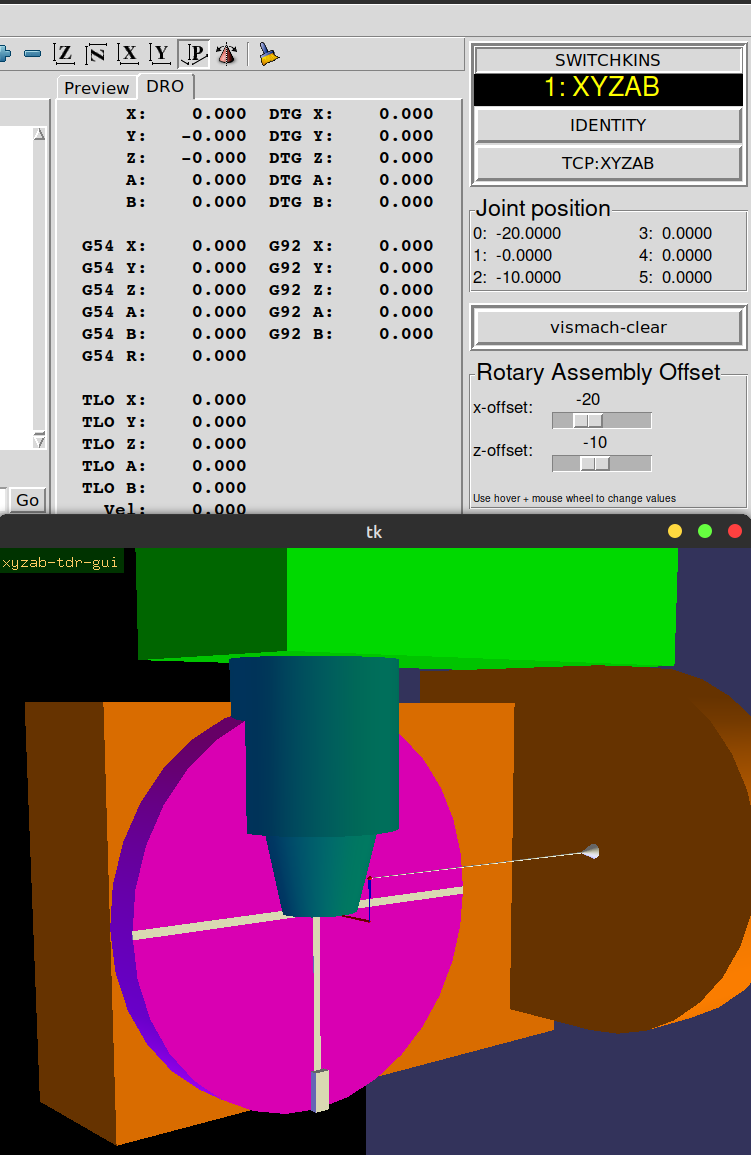

In [32]:
display(Image(filename="Images/aob_gui_v1.png",
              height=300, width=300))

## Shifting the reference point back to the rotation point

For the purpose of this example let's say we would like the machine reference to remain in the rotation point.<br>

### Forward kinematic
We set $P=(Px,Py,Pz)=(0,0,0)$ <br>
and $\theta_a = \theta_b = 0$ which gives $Sa=Sb=0,~ Ca=Cb=1$ <br>
With these input values our current forward kinematic

In [33]:
display(Math(rf'Q =~'+latex(Q_)+rf'=~'+latex(Q_out)))

<IPython.core.display.Math object>

results in $Q(-Dx,0,-Dz)$ 
Which is the reason our machine reference point has been moved to the face center of the rotary A. So in order to move the machine reference back to the rotation-point of the rotary assembly we need to add the offset values $(Dx,Dz)$ to the result of our forward kinematic which we can do in the form of a vector translation 

In [34]:
display(Math(rf'T_io =~'+latex(Tio)))

<IPython.core.display.Math object>

that is multiplied with our forward transformation matrix from the left.


\begin{equation} 
^QA_P=~ T_io \cdot R_s \cdot T_o \cdot R_p
\end{equation}

In [35]:
# calculate the forward transformation matrix
qAp=Tio*Rs*To*Rp
display(Math(rf'^QA_P =~~'+latex(Tio)+rf'\cdot'+latex(Rs)+rf'\cdot'+latex(To)+rf'\cdot'+latex(Rp)))
display(Math(rf'^QA_P =~~'+latex(qAp)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [36]:
# calculate the forward kinematic
Q_out=qAp*P_
display(Math(rf'Q =~'+latex(Q_)+rf'=~^QA_P \cdot P ='+latex(qAp)+rf'\cdot'+latex(P_)))
display(Math(rf'Q =~'+latex(Q_)+latex(Q_out)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [37]:
# Extract the tool-position vector Q (FORWARD KINEMATICS) from
# the fourth column of the forward transformation matrix
display(Math(latex(Q_[0][0]) + rf'~=~'  + latex(Q_out[0])))
display(Math(latex(Q_[1][0]) + rf'~=~'  + latex(Q_out[1])))
display(Math(latex(Q_[2][0]) + rf'~=~'  + latex(Q_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [38]:
# expressions as used in kinematics component
print('//TCP kinematics FORWARD')
print('pos->tran.x = ', Q_out[0], ';')
print('pos->tran.y = ', Q_out[1], ';')
print('pos->tran.z = ', Q_out[2], ';')

//TCP kinematics FORWARD
pos->tran.x =  (Cp*Px + Pz*Sp) ;
pos->tran.y =  (-Cp*Pz*Ss + Px*Sp*Ss + Cs*Py + Dz*Ss) ;
pos->tran.z =  (Cp*Cs*Pz - Cs*Px*Sp - Cs*Dz + Py*Ss + Dz) ;


### Inverse transformation

In the inverse transformation

\begin{equation}
 P=~^PA_Q \cdot Q =~ R_p^T\cdot  T_{io} \cdot  R_s^T \cdot Q 
\end{equation}

 we have to subtract the offset values $Dx,Dz$ from the input values $Q$:

In [39]:
Q_in=matrix([[Qx-Dx],
             [Qy],
             [Qz-Dz],
             [1]])
display(Math(rf'Q =~'+latex(Q_in)))

<IPython.core.display.Math object>

This is essentially the same as multiplying a translation vector to right side of our transformation matrix. To keep the math more readable we choose to subtract the values directly from the input.

In [40]:
# nothing has changed in the inverse transformation matrix
display(Math(rf'^PA_Q =~~'+latex(pAq)))

<IPython.core.display.Math object>

In [41]:
# calculate the inverse kinematic
P_out=pAq*Q_in
display(Math(rf'P =~'+latex(P_)+rf'=~'+latex(pAq)+rf'\cdot'+latex(Q_in)))
display(Math(rf'P =~'+latex(P_)+rf'=~'+latex(P_out)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [42]:
# Extract the joint-position vector P (INVERSE KINEMATICS) from
# the fourth column of the inverse transformation matrix
display(Math(latex(P_[0][0]) + rf'~=~'  + latex(P_out[0])))
display(Math(latex(P_[1][0]) + rf'~=~'  + latex(P_out[1])))
display(Math(latex(P_[2][0]) + rf'~=~'  + latex(P_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [43]:
# expressions as used in kinematics component
print('//TCP kinematics INVERSE')
print('j[0] = ', P_out[0], ';')
print('j[1] = ', P_out[1], ';')
print('j[2] = ', P_out[2], ';')

//TCP kinematics INVERSE
j[0] =  (Cs*(Dz - Qz)*Sp + Qy*Sp*Ss - Cp*(Dx - Qx) + Cp*Dx - Dz*Sp) ;
j[1] =  (Cs*Qy - (Dz - Qz)*Ss) ;
j[2] =  (-Cp*Cs*(Dz - Qz) - Cp*Qy*Ss + Cp*Dz - (Dx - Qx)*Sp + Dx*Sp) ;


Note that in the kinematic component Dx is subtracted from the coordinate value pos->tran.x in the line Qx = pos->tran.x - Qx;<br>
and Dz is subtracted from the coordinate value pos->tran.z in the line Qz = pos->tran.z - Dz;<br>
Also note that  $(Dz−Qz)=−(Qz−Dz)$

Testing in LinuxCNC shows the machine reference point has now been shifted back to rotation point of the rotary assembly.

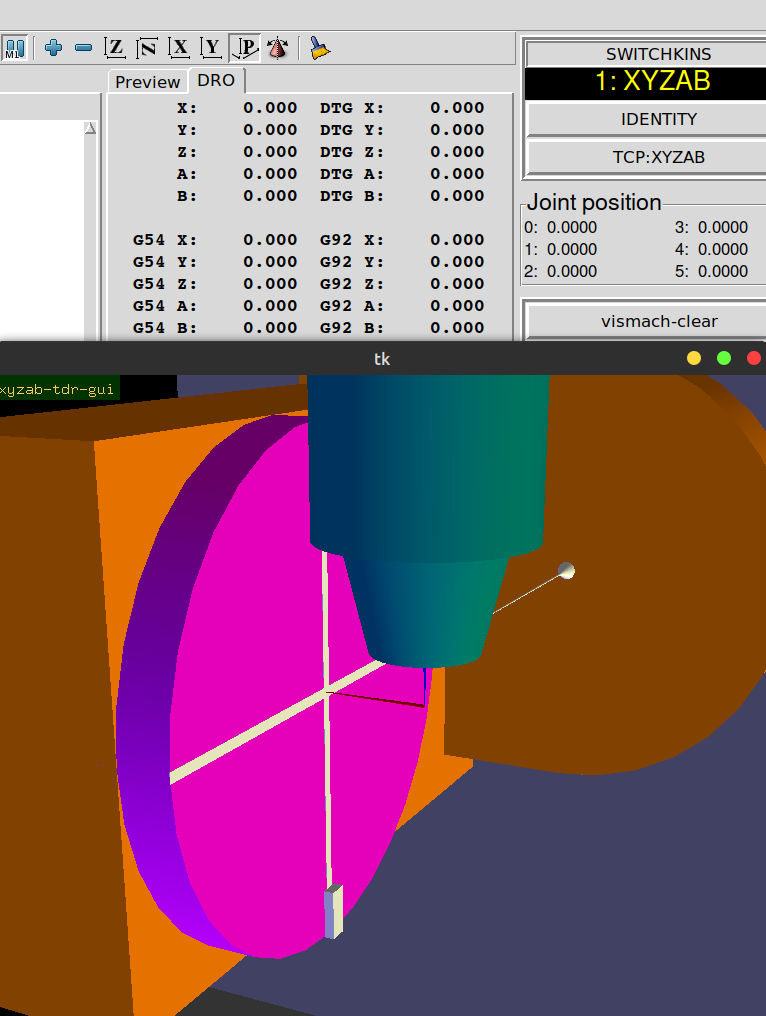

In [44]:
display(Image(filename="Images/aob_gui_v2.png", 
              height=300, width=300))

## Tool length offset (TLO)

Tool-length compensation is applied automatically in LinuxCNC by subtracting the tool-length value *Dt* stored in the tool table from the the z-axis coordinate position while the joint position value remains unchanged. In it's current form our forward kinematic model assumes that the joint position $P$ is identical to the tool position and uses the joint position value $P(Px,Py,Pz)$ to calculate the coordinate value $Q(Qx,Qy,Qz)$. Hence our kinematic model does not see a tool position change when TLO is activated by G43.


### Forward kinematics

To illustrate the situation we assume that the machine coordinate system origin (ie G53 X0Y0Z0) coincides with the rotation point of our rotary assembly. Further assuming that a tool could be positioned in this location we would expect that without any tool-length compensation (G49) a tool positioned here (G0 X0Y0Z0) would be unaffected by any rotation of either A or B and that is indeed the case:


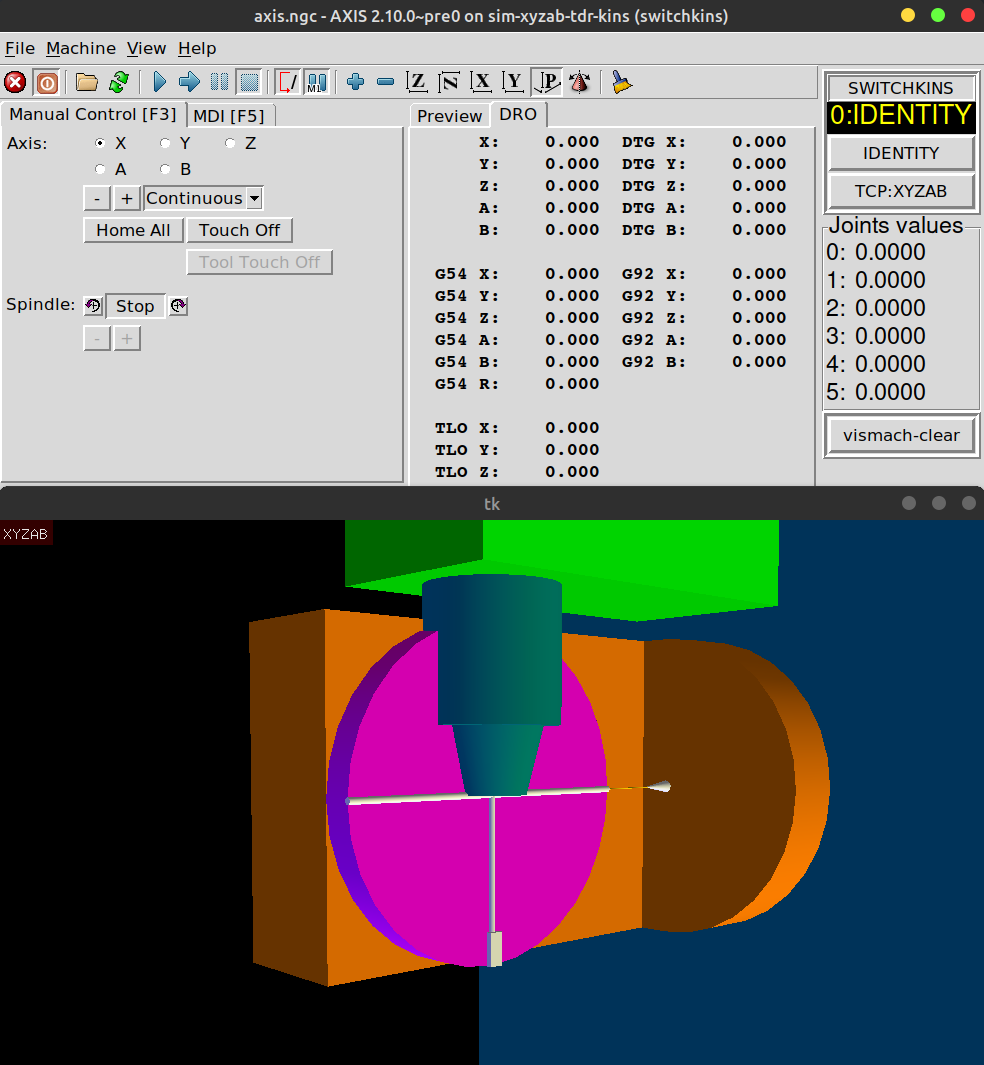

In [45]:
display(Image(filename="Images/offsets_tool_1.png",
              height=300, width=300))

Let us consider this with our forward kinematic: 

In [46]:
display(Math(rf'Q =~'+latex(Q_)+rf'=~'+latex(Q_out)))

<IPython.core.display.Math object>

It is easy to see that for $Dx=Dz=0$ and $P(0,0,0)$ the result is indeed $Q(0,0,0)$ and this is what we expected.
<br>
<br>

However if we apply tool-length compensation (ie G43) and we move the tool to G0 X0Y0Z0  so the tool center point (TCP) is again positioned at the rotation-point we see that the input to our forward kinematic (ie the joint position) is not at $P(0,0,0)$ anymore:

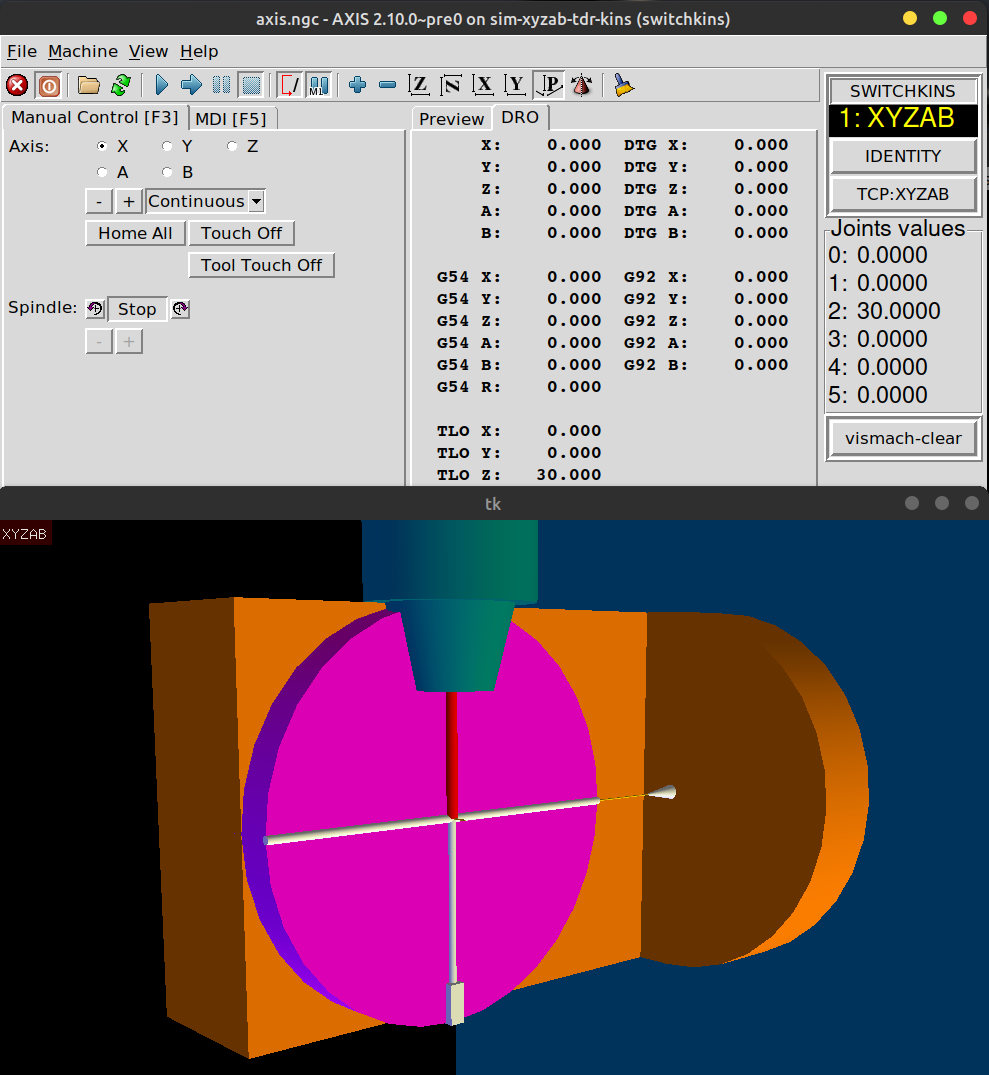

In [47]:
display(Image(filename="Images/offsets_tool_2.png",
              height=300, width=300))

Due to the way TLO is handled by LinuxCNC our joint-position is now *P(0,0,Dt)* while the DRO reads *Z: 0.000*.<br>
To solve this problem we need to subtract the tool-offset value *Dt* from the z joint position before feeding it into the forward kinematic. In this way our joint-position becomes $P(0,0,0)$ which will then give us the desired result of $Q(0,0,0)$. <br>


In [48]:
var('Dt')
P_in=matrix([[Px],
             [Py],
             [Pz-Dt],
             [1]])
display(Math(rf'P =~'+latex(P_in)))

<IPython.core.display.Math object>

Now however there is a new problem in that the DRO in LinuxCNC will show a z-axis position value equivalent to *-Dt*.

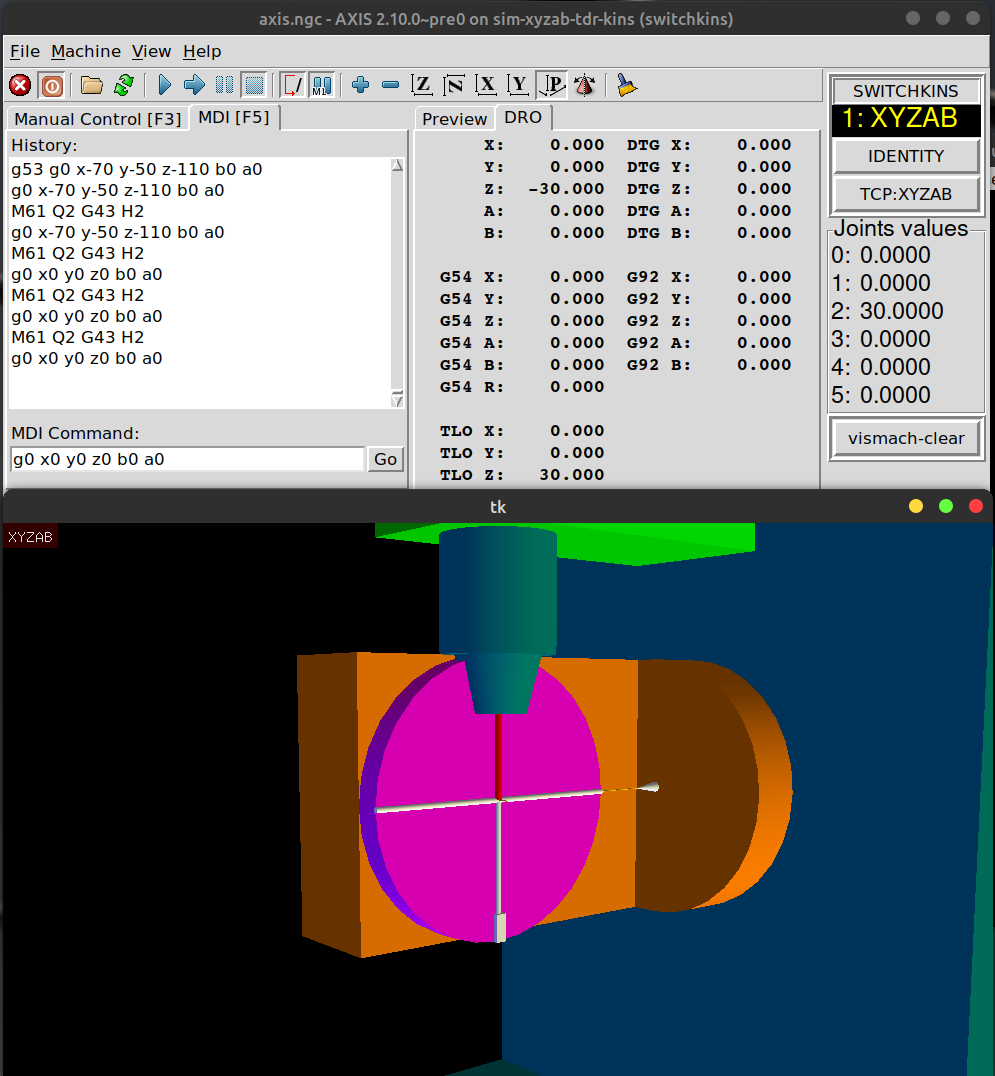

In [49]:
display(Image(filename="Images/offsets_tool_3.png",
              height=300, width=300))

This is because LinuxCNC automatically subtracts the TLO value from the value of *pos->tran.z* which is the result of our forward kinematic.<br>
This can be fixed by adding *Dt* back to the result of our forward kinematic calculation which we can do by creating a vector translation: 


In [50]:
Tt=matrix([[ 1, 0, 0, 0],
           [ 0, 1, 0, 0],
           [ 0, 0, 1, Dt],
           [ 0, 0, 0, 1 ]])

display(Math(rf'Tt=~'+latex(Tt)))



<IPython.core.display.Math object>

and multiply that to the left of our transformation matrix:


\begin{equation}
 ^QA_P=~ T_t \cdot T_{io} \cdot R_s \cdot T_o \cdot R_p
\end{equation}

In [51]:
# calculate the forward transformation matrix
qAp=Tt*Tio*Rs*To*Rp
display(Math(rf'^QA_P =~~'+latex(Tt)+rf'\cdot'+latex(Tio)+rf'\cdot'+latex(Rs)+rf'\cdot'+latex(To)+rf'\cdot'+latex(Rp)))
display(Math(rf'^QA_P =~~'+latex(qAp)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [52]:
# calculate forward kinematic
Q_out=qAp*P_in
display(Math(rf'Q =~'+latex(Q_)+rf'=~^QA_P \cdot P=~'+latex(qAp)+rf'\cdot'+latex(P_in)))
display(Math(rf'Q =~'+latex(Q_out)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [53]:
# Extract the tool-position vector Q (FORWARD KINEMATICS) from
# the fourth column of the forward transformation matrix
display(Math(latex(Q_[0][0]) + rf'~=~'  + latex(Q_out[0])))
display(Math(latex(Q_[1][0]) + rf'~=~'  + latex(Q_out[1])))
display(Math(latex(Q_[2][0]) + rf'~=~'  + latex(Q_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [54]:
# expressions as used in kinematics component
print('//TCP kinematics FORWARD')
print('pos->tran.x = ', Q_out[0], ';')
print('pos->tran.y = ', Q_out[1], ';')
print('pos->tran.z = ', Q_out[2], ';')

//TCP kinematics FORWARD
pos->tran.x =  (Cp*Px - (Dt - Pz)*Sp) ;
pos->tran.y =  (Cp*(Dt - Pz)*Ss + Px*Sp*Ss + Cs*Py + Dz*Ss) ;
pos->tran.z =  (-Cp*Cs*(Dt - Pz) - Cs*Px*Sp - Cs*Dz + Py*Ss + Dt + Dz) ;


Note that in the kinematic component $Dt$ is subtracted from the joint value *j[2]* in the line <br>
*pz = j[2]- dt;*
Also note that  $(Dz−Qz)=−(Qz−Dz)$

### Inverse transformation

For the inverse transformation to match the new forward transformation we need to subtract $Dt$ from the coordinate position $Q$ and add it back to the result which we do by multiplying the translation by the vector $Dt$ from the left:


\begin{equation}
 P=~^PA_Q \cdot Q =~ T_t \cdot R_p^T\cdot  T_{io} \cdot  R_s^T \cdot Q 
\end{equation}


In [55]:
Q_in=matrix([[Qx-Dx],
             [Qy],
             [Qz-Dz-Dt],
             [1]])
display(Math(rf'Q =~'+latex(Q_in)))

<IPython.core.display.Math object>

In [56]:
# calculate the inverse transformation matrix
pAq=Tt*Rp.transpose()*Tio*Rs.transpose()
display(Math(rf'^PA_Q =~~'+latex(Tt)+rf'\cdot'+latex(Rp.transpose())+rf'\cdot'+latex(Tio)+rf'\cdot'+latex(Rs.transpose())))
display(Math(rf'^PA_Q =~~'+latex(pAq)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [57]:
P_out=pAq*Q_in
display(Math(rf'P =~'+latex(P_)+rf'=~^PA_Q \cdot Q=~'+latex(pAq)+rf'\cdot'+latex(Q_in)))
display(Math(rf'P =~'+latex(P_out)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [58]:
# Extract the joint-position vector P (INVERSE KINEMATICS) from
# the fourth column of the inverse transformation matrix
display(Math(latex(P_[0][0]) + rf'~=~'  + latex(P_out[0])))
display(Math(latex(P_[1][0]) + rf'~=~'  + latex(P_out[1])))
display(Math(latex(P_[2][0]) + rf'~=~'  + latex(P_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [59]:
# expressions as used in kinematics component
print('//TCP kinematics INVERSE')
print('j[0] = ', P_out[0], ';')
print('j[1] = ', P_out[1], ';')
print('j[2] = ', P_out[2], ';')

//TCP kinematics INVERSE
j[0] =  (Cs*(Dt + Dz - Qz)*Sp + Qy*Sp*Ss - Cp*(Dx - Qx) + Cp*Dx - Dz*Sp) ;
j[1] =  (Cs*Qy - (Dt + Dz - Qz)*Ss) ;
j[2] =  (-Cp*Cs*(Dt + Dz - Qz) - Cp*Qy*Ss + Cp*Dz - (Dx - Qx)*Sp + Dx*Sp + Dt) ;


Note that in the kinematic component $Dx$ is subtracted from the coordinate value *pos->tran.x* in the line<br>
*Qx = pos->tran.x - Dx;*<br>
Note that in the kinematic component $Dt$ and $Dz$  are subtracted from the coordinate value *pos->tran.x*  in the line <br>
*Qz = pos->tran.z - Dz - Dt;*<br>
Also note that  $(Dz−Qz)=−(Qz−Dz)$

Now everything looks correct in the DRO.

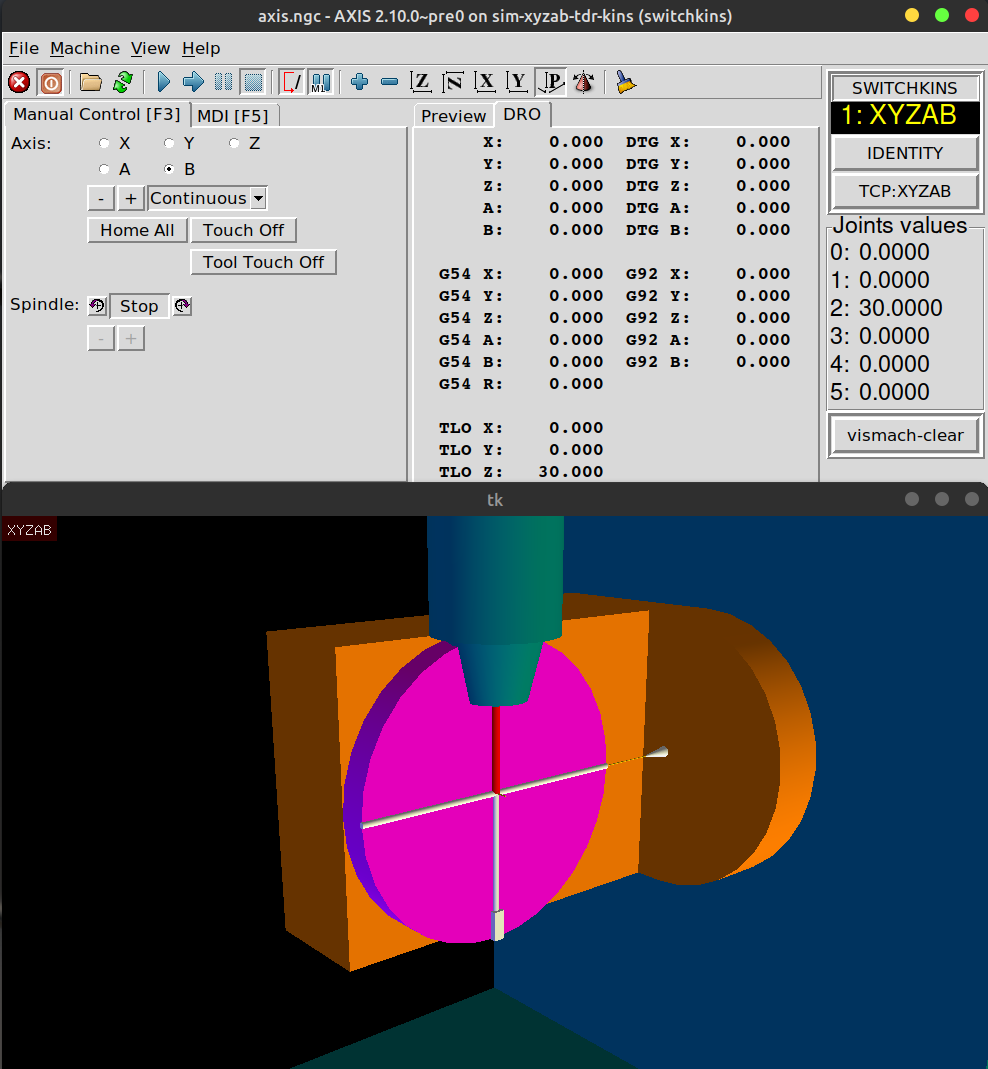

In [60]:
display(Image(filename="Images/offsets_tool_4.png",
              height=300, width=300))

If our machine is setup so that the machine reference point coincides with the rotation point of our rotary-assembly then our forward kinematic is complete. Otherwise one more step is necessary to derive a correct kinematic model.


## Position offset of the rotary assembly to the machine reference point
 
Up to this point we have assumed that the machine reference point coincides with the rotation point of our rotary-assembly or in case of applied geometric offsets $(Dx, Dz)$ maybe the center of the face of our secondary rotary table A. For such a case our forward kinematic is complete.
However, if the machine at hand is setup in a way where there is an offset between the machine reference point and the rotary-assembly then this will need to be taken into account in the kinematic model.<br>
What does such an offset mean for our forward kinematic? 

### Forward kinematic

Let us assume that we have a setup with no TLO ($dt=0$), no geometric offset ($Dz=Dx=0$) and no offset of the rotation-point. A tool positioned at the rotation-point would have a joint-position of $P(0,0,0)$ and that would give the expected resulting coordinate position of $Q(0,0,0)$. If we now assume that the rotation-point of our rotary-assembly is offset from the machine reference point by $(rp_x,rp_y,rp_z)$ then our joint-position would be equal to the offset $P(rp_x,rp_y,rp_z)$ which would clearly not give us the required result of Q(0,0,0).<br>
So we need to subtract the offset $(rp_x,rp_y,rp_z)$ from the joint-position $P=(Px-rp_x, Py-rp_y, Pz-rp_z)$  or in other words we need to translate the joint-position vector in the opposite direction along the offset vector. 

In [61]:
var('Drpx','Drpy','Drpz')
P_in=matrix([[Px-Drpx],
             [Py-Drpy],
             [Pz-Drpz-Dt],
             [1]])

display(Math(rf'P =~'+latex(P_in)))



<IPython.core.display.Math object>

However some more consideration is needed for now a joint position of $P(rp_x,rp_y,rp_z)$ will result in a coordinate position of $Q(0,0,0)$ which is of course not the value we can hand back to LinuxCNC because if the rotation point is offset from machine zero then the coordinate position would be $Q(rp_x,rp_y,rp_z)$.<br> 
So to be consistent we need to add the offset values back to the results of our calculations which we do again by multiplying a vector translation to the left of our forward kinematic:


\begin{equation}
 ^QA_P=~ T_{rp} \cdot T_t \cdot T_{io} \cdot R_s \cdot T_o \cdot R_p
\end{equation}


In [62]:
Trp=matrix([[ 1, 0, 0, Drpx],
            [ 0, 1, 0, Drpy],
            [ 0, 0, 1, Drpz],
            [ 0, 0, 0,  1  ]])
display(Math(rf'Trp =~'+latex(Trp)))

<IPython.core.display.Math object>

In [63]:
# calculate the forward transformation matrix
qAp=Trp*Tt*Tio*Rs*To*Rp
display(Math(rf'^QA_P =~~'+latex(Tt)+rf'\cdot'+latex(Tio)+rf'\cdot'+latex(Rs)+rf'\cdot'+latex(To)+rf'\cdot'+latex(Rp)))
display(Math(rf'^QA_P =~~'+latex(qAp)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [64]:
Q_out=qAp*P_in
display(Math(rf'Q =~'+latex(Q_)+rf'=~ ^QA_P \cdot P=~'+latex(qAp)+rf'\cdot'+latex(P_in)))
display(Math(rf'Q =~'+latex(Q_out)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [65]:
# Extract the tool-position vector Q (FORWARD KINEMATICS) from
# the fourth column of the forward transformation matrix
display(Math(latex(Q_[0][0]) + rf'~=~'  + latex(Q_out[0])))
display(Math(latex(Q_[1][0]) + rf'~=~'  + latex(Q_out[1])))
display(Math(latex(Q_[2][0]) + rf'~=~'  + latex(Q_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [66]:
# expressions as used in kinematics component
print('//TCP kinematics FORWARD')
print('pos->tran.x = ', Q_out[0], ';')
print('pos->tran.y = ', Q_out[1], ';')
print('pos->tran.z = ', Q_out[2], ';')

//TCP kinematics FORWARD
pos->tran.x =  (-Cp*(Drpx - Px) - (Drpz + Dt - Pz)*Sp + Drpx) ;
pos->tran.y =  (Cp*(Drpz + Dt - Pz)*Ss - (Drpx - Px)*Sp*Ss - Cs*(Drpy - Py) + Dz*Ss + Drpy) ;
pos->tran.z =  (-Cp*Cs*(Drpz + Dt - Pz) + Cs*(Drpx - Px)*Sp - Cs*Dz - (Drpy - Py)*Ss + Drpz + Dt + Dz) ;


Note that in the kinematic component $Drp(x,y,z)$ is named *(x,y,z)_rot_point* and subtracted from the respective joint values in the lines *<br>
        px          = j[0] - x_rot_point;<br>
        py          = j[1] - y_rot_point;<br>
        pz          = j[2] - z_rot_point - dt;*<br>
Also note that  $(Dz−Qz)=−(Qz−Dz)$

        case 1: // ========================= TCP kinematics FORWARD 
            px          = j[0] - x_rot_point;
            py          = j[1] - y_rot_point;
            pz          = j[2] - z_rot_point - dt;

            pos->tran.x =   cb*px + sb*pz
                          + x_rot_point;

            pos->tran.y =   sa*sb*px + ca*py - cb*sa*pz + sa*dz
                          + y_rot_point;

            pos->tran.z = - ca*sb*px + sa*py + ca*cb*pz - ca*dz
                          + z_rot_point + dz + dt;

            pos->a      = j[3];
            pos->b      = j[4];
            pos->c      = j[5];
            break;

### Inverse transformation

For the inverse transformation to match the new forward transformation we need mirror the modifications in the forward kinematics. That means to subtract $Drp(x,y,z)$ from the coordinate position $Q$

In [67]:
Q_in=matrix([[Qx-Drpx-Dx],
             [Qy-Drpy],
             [Qz-Drpz-Dz],
             [1]])
display(Math(rf'Q =~'+latex(Q_in)))

<IPython.core.display.Math object>

 and add it back to the result which we do by multiplying the translation vector $Drp(x,y,z)$ to the inverse transformation from the left:


\begin{equation}
^PA_Q =~T_{rp} \cdot~ T_t \cdot R_p^T\cdot  T_{io} \cdot  R_s^T 
\end{equation}


In [68]:
# calculate the inverse transformation matrix
pAq=Trp*Tt*Rp.transpose()*Tio*Rs.transpose()
display(Math(rf'^PA_Q =~~'+latex(Trp)+rf'\cdot'+latex(Tt)+rf'\cdot'+latex(Rp.transpose())+rf'\cdot'+latex(Tio)+rf'\cdot'+latex(Rs.transpose())))
display(Math(rf'^PA_Q =~~'+latex(pAq)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

\begin{equation}
 P=~^PA_Q \cdot Q 
\end{equation}


In [69]:
P_out=pAq*Q_in
display(Math(rf'P =~'+latex(P_)+rf'=~^PA_Q \cdot Q=~'+latex(pAq)+rf'\cdot'+latex(Q_in)))
display(Math(rf'P =~'+latex(P_out)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [70]:
# Extract the joint-position vector P (INVERSE KINEMATICS) from
# the fourth column of the inverse transformation matrix
display(Math(latex(P_[0][0]) + rf'~=~'  + latex(P_out[0])))
display(Math(latex(P_[1][0]) + rf'~=~'  + latex(P_out[1])))
display(Math(latex(P_[2][0]) + rf'~=~'  + latex(P_out[2])))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [71]:
# expressions as used in kinematics component
print('//TCP kinematics INVERSE')
print('j[0] = ', P_out[0], ';')
print('j[1] = ', P_out[1], ';')
print('j[2] = ', P_out[2], ';')

//TCP kinematics INVERSE
j[0] =  (Cs*(Drpz + Dz - Qz)*Sp - (Drpy - Qy)*Sp*Ss - Cp*(Drpx + Dx - Qx) + Cp*Dx - Dz*Sp + Drpx) ;
j[1] =  (-Cs*(Drpy - Qy) - (Drpz + Dz - Qz)*Ss + Drpy) ;
j[2] =  (-Cp*Cs*(Drpz + Dz - Qz) + Cp*(Drpy - Qy)*Ss + Cp*Dz - (Drpx + Dx - Qx)*Sp + Dx*Sp + Drpz + Dt) ;


Note that in the kinematic component $Drp(x,y,z)$ is named *(x,y,z)_rot_point* and subtracted from the respective coordinate values in the lines *<br>
            qx   = pos->tran.x - x_rot_point - dx;<br>
            qy   = pos->tran.y - y_rot_point;<br>
            qz   = pos->tran.z - z_rot_point - dz - dt;*

Note that in the kinematic component $Dx$ is subtracted from the coordinate value *pos->tran.x* in the line<br>
            qx   = pos->tran.x - x_rot_point - dx;<br>
Note that in the kinematic component $Dt$ and $Dz$  are subtracted from the coordinate value *pos->tran.x*  in the line <br>
            qz   = pos->tran.z - z_rot_point - dz - dt;*<br>
Also note that  $(Dz−Qz)=−(Qz−Dz)$



        case 1: // ========================= TCP kinematics INVERSE ======================
            qx   = pos->tran.x - x_rot_point - dx;
            qy   = pos->tran.y - y_rot_point;
            qz   = pos->tran.z - z_rot_point - dz - dt;

            j[0] =   cb*qx + sa*sb*qy - ca*sb*qz + cb*dx - sb*dz
                   + x_rot_point;

            j[1] =   ca*qy + sa*qz
                   + y_rot_point;

            j[2] =   sb*qx - sa*cb*qy + ca*cb*qz + sb*dx + cb*dz
                   + z_rot_point + dt;

            j[3] = pos->a;
            j[4] = pos->b;
            break;

This completes the kinematic model.<br>
